In [18]:
# Load in the necessary modules for plotting and Pytorch
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch import Tensor
from torch.nn import Sequential as Seq, Linear, ReLU, Sigmoid, ModuleList, init
import torch_sparse

#from torch_cluster import radius_graph
from torch_geometric.nn import radius_graph

import torch_geometric
from torch_geometric.utils import degree
from torch_geometric.nn import MessagePassing
import torch_geometric.transforms as T
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, ChebConv, GATConv
#from torch_geometric.nn import GATConv
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
#from torch import cdist
from scipy.spatial.distance import cdist

import math
from collections import defaultdict

from astropy.table import Table
from astropy.coordinates import SkyCoord, CartesianRepresentation, Galactocentric
import astropy.units as u

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.interpolate import interp1d

import time

print('Modules loaded :)')

# check the device for macbook MPS or cpu
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#print(f'cuda is available: {torch.cuda.is_available()}')
#device = torch.device("cpu")
print(f"Device: {device}")

Modules loaded :)
Device: mps


In [2]:
## Benchmarking cdist and radius_graph

# Generate random node features
N = 20000  # Number of nodes
N_features = 3     # Number of features (e.g., 3D coordinates)
# pytorch random number seed
torch.manual_seed(42)
x = torch.rand((N, N_features))

# Radius threshold
r = 1e-1

# Benchmark cdist
'''start_time = time.time()
distances = cdist(x, x)
edges_cdist = (np.argwhere(distances < r))
#edges_cdist = edges_cdist[edges_cdist[:, 0] != edges_cdist[:, 1]]  # Exclude self-loops
edges_cdist = torch.tensor(edges_cdist, dtype=torch.long).t()
#edges_cdist = set((i, j) for i in range(N) for j in range(N) if distances[i, j] <= r and i != j)
cdist_time = time.time() - start_time
print(f"cdist time: {cdist_time:.4f} seconds")
print(f'cdist array shape: {edges_cdist.shape}')
'''# Benchmark radius_graph
start_time = time.time()
edges_radius_graph = radius_graph(x, r=r, loop=True, max_num_neighbors=N)
#radius_graph_edges = set(tuple(edge) for edge in edges_radius_graph.t().tolist())
radius_graph_time = time.time() - start_time
print(f"radius_graph time: {radius_graph_time:.4f} seconds")
print(f'radius_graph array shape: {edges_radius_graph.shape}')

radius_graph time: 0.0958 seconds
radius_graph array shape: torch.Size([2, 1509970])


In [4]:
# Size of matrices to multiply
N = 10000

# Create two random matrices
A = torch.randn(N, N)
B = torch.randn(N, N)

# CPU matrix multiplication
start_time = time.time()
result_cpu = torch.mm(A, B)
cpu_time = time.time() - start_time
print(f"Time taken on CPU: {cpu_time:.5f} seconds")

# Check if CUDA is available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    A = A.to(device)
    B = B.to(device)
    
    # GPU matrix multiplication
    start_time = time.time()
    result_gpu = torch.mm(A, B)
    gpu_time = time.time() - start_time
    print(f"Time taken on GPU: {gpu_time:.5f} seconds")
else:
    print("CUDA is not available.")


Time taken on CPU: 1.20643 seconds
Time taken on GPU: 0.03846 seconds


In [3]:
# Set up matplotlib settings
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D


plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 12  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 10  # Set the font size of the legend

# ... Additional settings as needed ...


In [4]:
# Load the data
data_path = './gd1-with-masks.fits'
gd1_data = Table.read(data_path)

In [5]:
print(f'Data Keys: {gd1_data.keys()}')
print(f'Number of stars: {len(gd1_data["source_id"])}')
print(f'Number of pm members: {np.sum(gd1_data["pm_mask"])}')
print(f'Number of gi members: {np.sum(gd1_data["gi_cmd_mask"])}')
print(f'Number of pm and gi members: {np.sum(gd1_data["pm_mask"] & gd1_data["gi_cmd_mask"])}')

Data Keys: ['source_id', 'ra', 'dec', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'visibility_periods_used', 'phot_g_mean_mag', 'phot_g_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_bp_mean_flux_over_error', 'phot_rp_mean_mag', 'phot_rp_mean_flux_over_error', 'phot_bp_rp_excess_factor', 'astrometric_chi2_al', 'astrometric_n_good_obs_al', 'g', 'g_error', 'g0', 'r', 'r_error', 'r0', 'i', 'i_error', 'i0', 'z', 'z_error', 'z0', 'y', 'y_error', 'y0', 'pm_mask', 'gi_cmd_mask', 'phi1', 'phi2', 'pm_phi1_cosphi2_no_reflex', 'pm_phi2_no_reflex', 'pm_phi1_cosphi2', 'pm_phi2', 'stream_track_mask']
Number of stars: 7248422
Number of pm members: 100675
Number of gi members: 510451
Number of pm and gi members: 5945


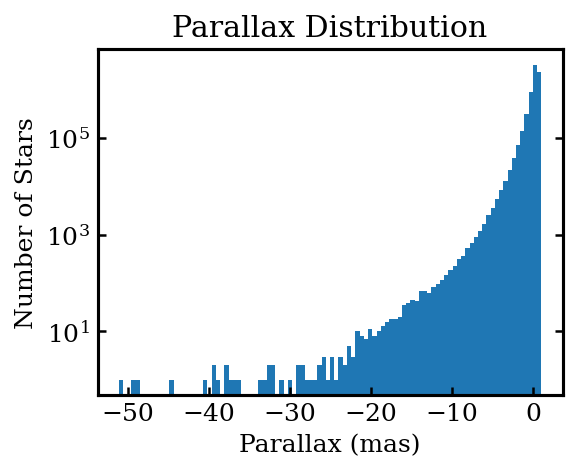

In [9]:
# histogram of the parallax values
plt.figure(figsize=(4, 3))
plt.hist(gd1_data['parallax'], bins=100,log=True)
plt.xlabel('Parallax (mas)')
plt.ylabel('Number of Stars')
plt.title('Parallax Distribution')
plt.show()

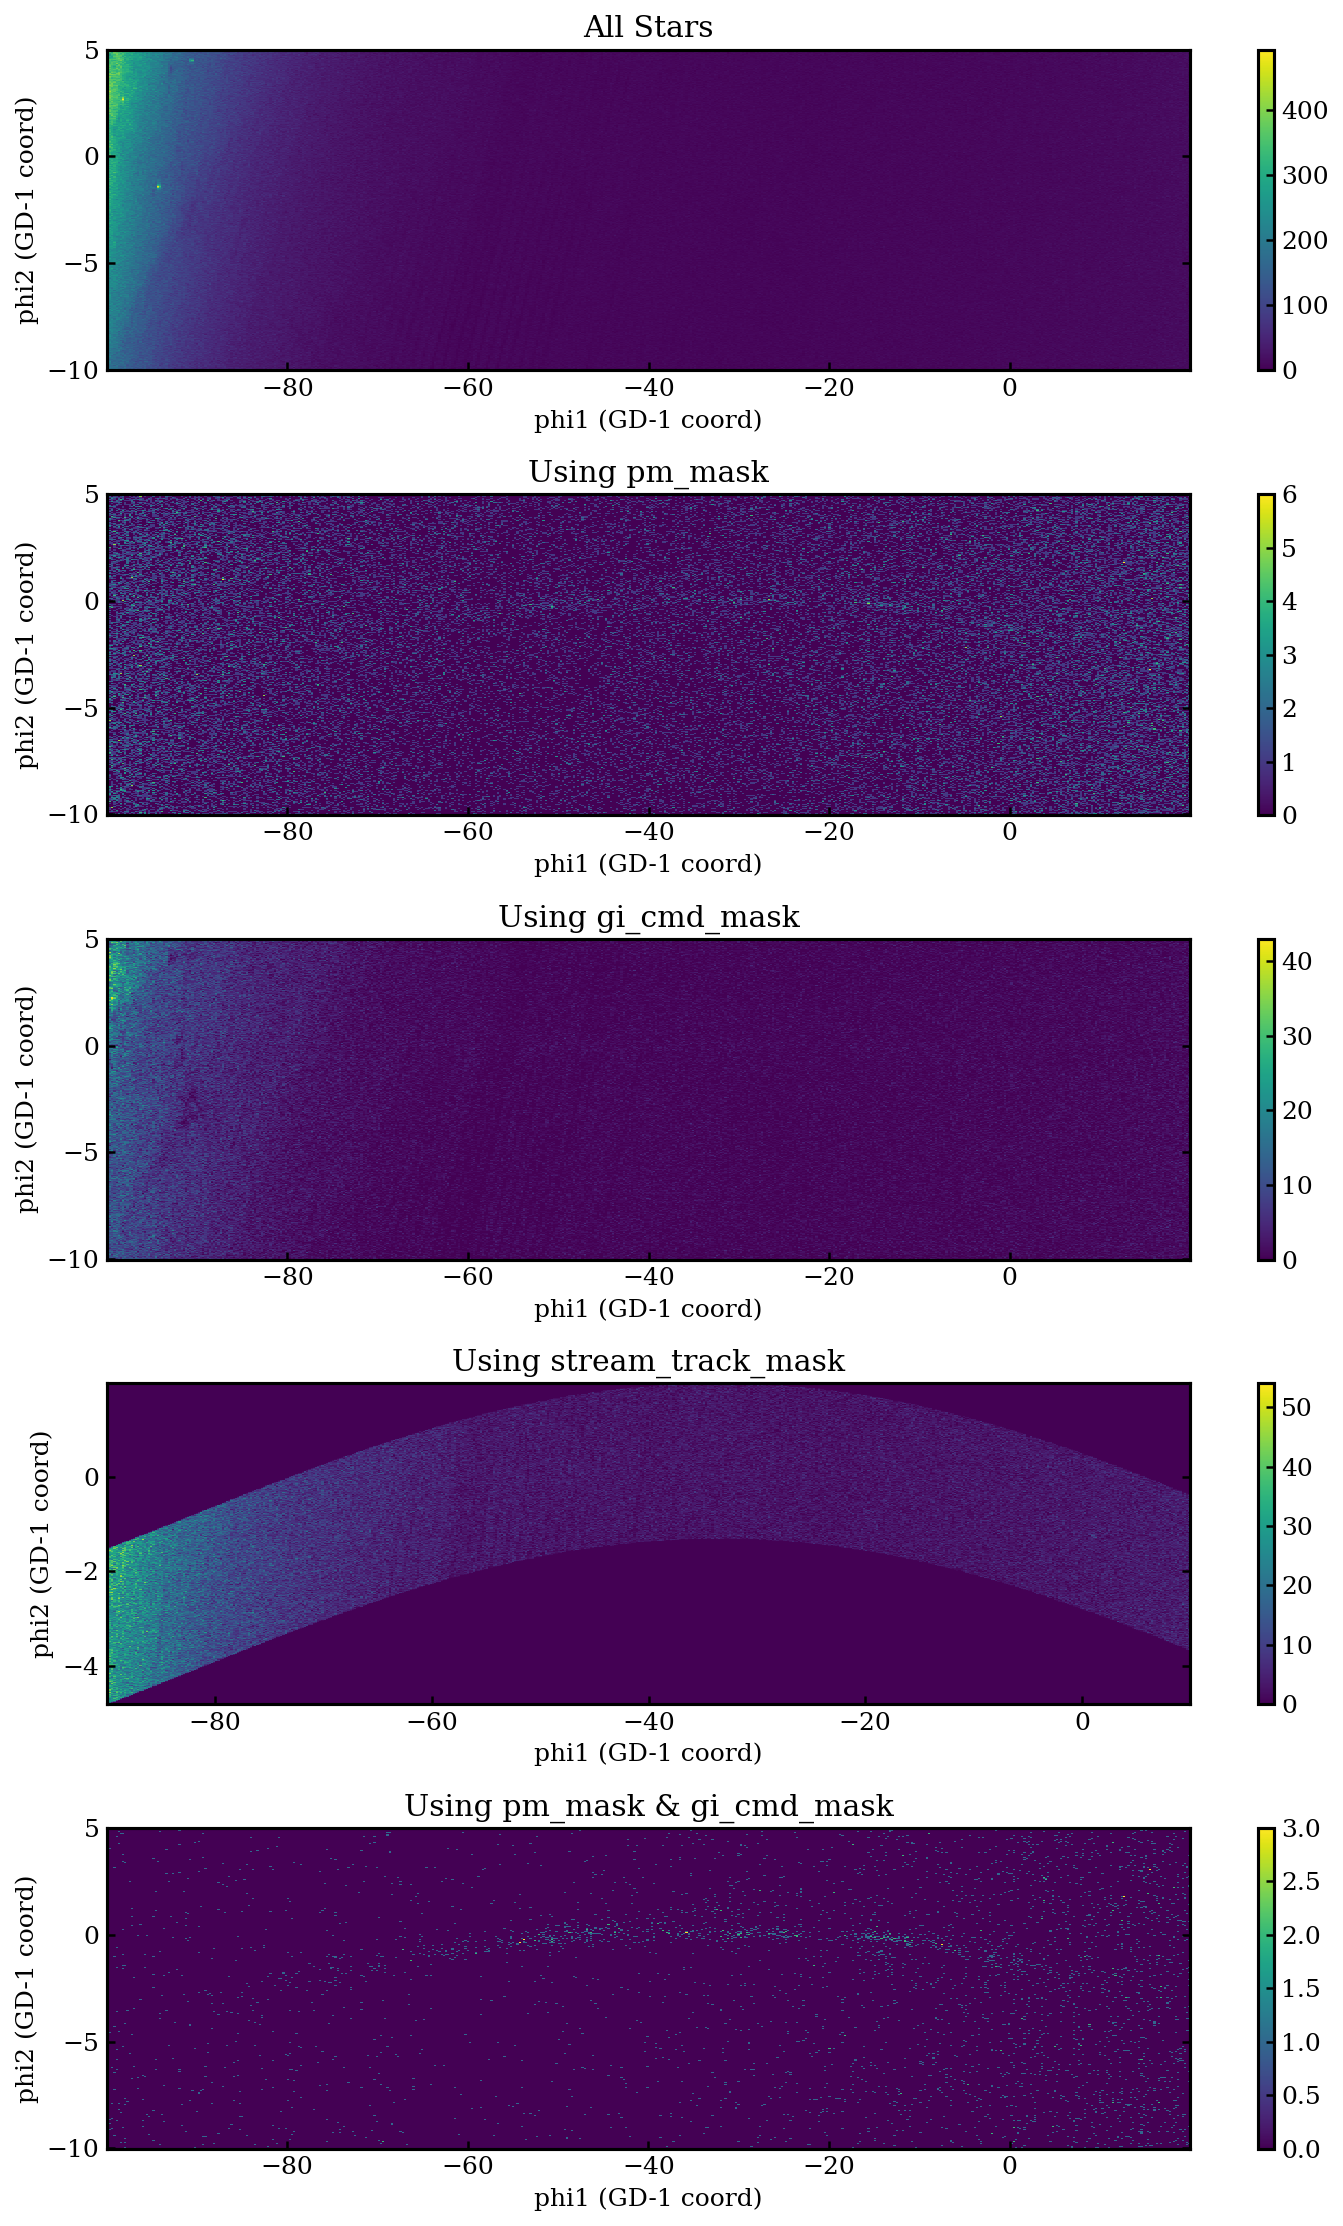

In [8]:
# visualising the stars with the different masks

# Create a 5-row figure for the five histograms
fig, axes = plt.subplots(nrows=5, figsize=(10, 15))

# 1. All phi1, phi2 coordinates (raw)
h = axes[0].hist2d(gd1_data['phi1'], gd1_data['phi2'], bins=500, cmap='viridis', norm=None)
axes[0].set_title('All Stars')
axes[0].set_xlabel('phi1 (GD-1 coord)')
axes[0].set_ylabel('phi2 (GD-1 coord)')
fig.colorbar(h[3], ax=axes[0])

# 2. Using pm_mask
masked_data = gd1_data[gd1_data['pm_mask']]
h = axes[1].hist2d(masked_data['phi1'], masked_data['phi2'], bins=500, cmap='viridis', norm=None)
axes[1].set_title('Using pm_mask')
axes[1].set_xlabel('phi1 (GD-1 coord)')
axes[1].set_ylabel('phi2 (GD-1 coord)')
fig.colorbar(h[3], ax=axes[1])

# 3. Using gi_cmd_mask
masked_data = gd1_data[gd1_data['gi_cmd_mask']]
h=axes[2].hist2d(masked_data['phi1'], masked_data['phi2'], bins=500, cmap='viridis', norm=None)
axes[2].set_title('Using gi_cmd_mask')
axes[2].set_xlabel('phi1 (GD-1 coord)')
axes[2].set_ylabel('phi2 (GD-1 coord)')
fig.colorbar(h[3], ax=axes[2])

# 4. Using stream_track_mask
masked_data = gd1_data[gd1_data['stream_track_mask']]
h=axes[3].hist2d(masked_data['phi1'], masked_data['phi2'], bins=500, cmap='viridis', norm=None)
axes[3].set_title('Using stream_track_mask')
axes[3].set_xlabel('phi1 (GD-1 coord)')
axes[3].set_ylabel('phi2 (GD-1 coord)')
fig.colorbar(h[3], ax=axes[3])

# 5. Combining pm_mask and gi_cmd_mask
masked_data = gd1_data[gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']]
h=axes[4].hist2d(masked_data['phi1'], masked_data['phi2'], bins=500, cmap='viridis', norm=None)
axes[4].set_title('Using pm_mask & gi_cmd_mask')
axes[4].set_xlabel('phi1 (GD-1 coord)')
axes[4].set_ylabel('phi2 (GD-1 coord)')
fig.colorbar(h[3], ax=axes[4])

# Adjust the layout
plt.tight_layout()
plt.show()

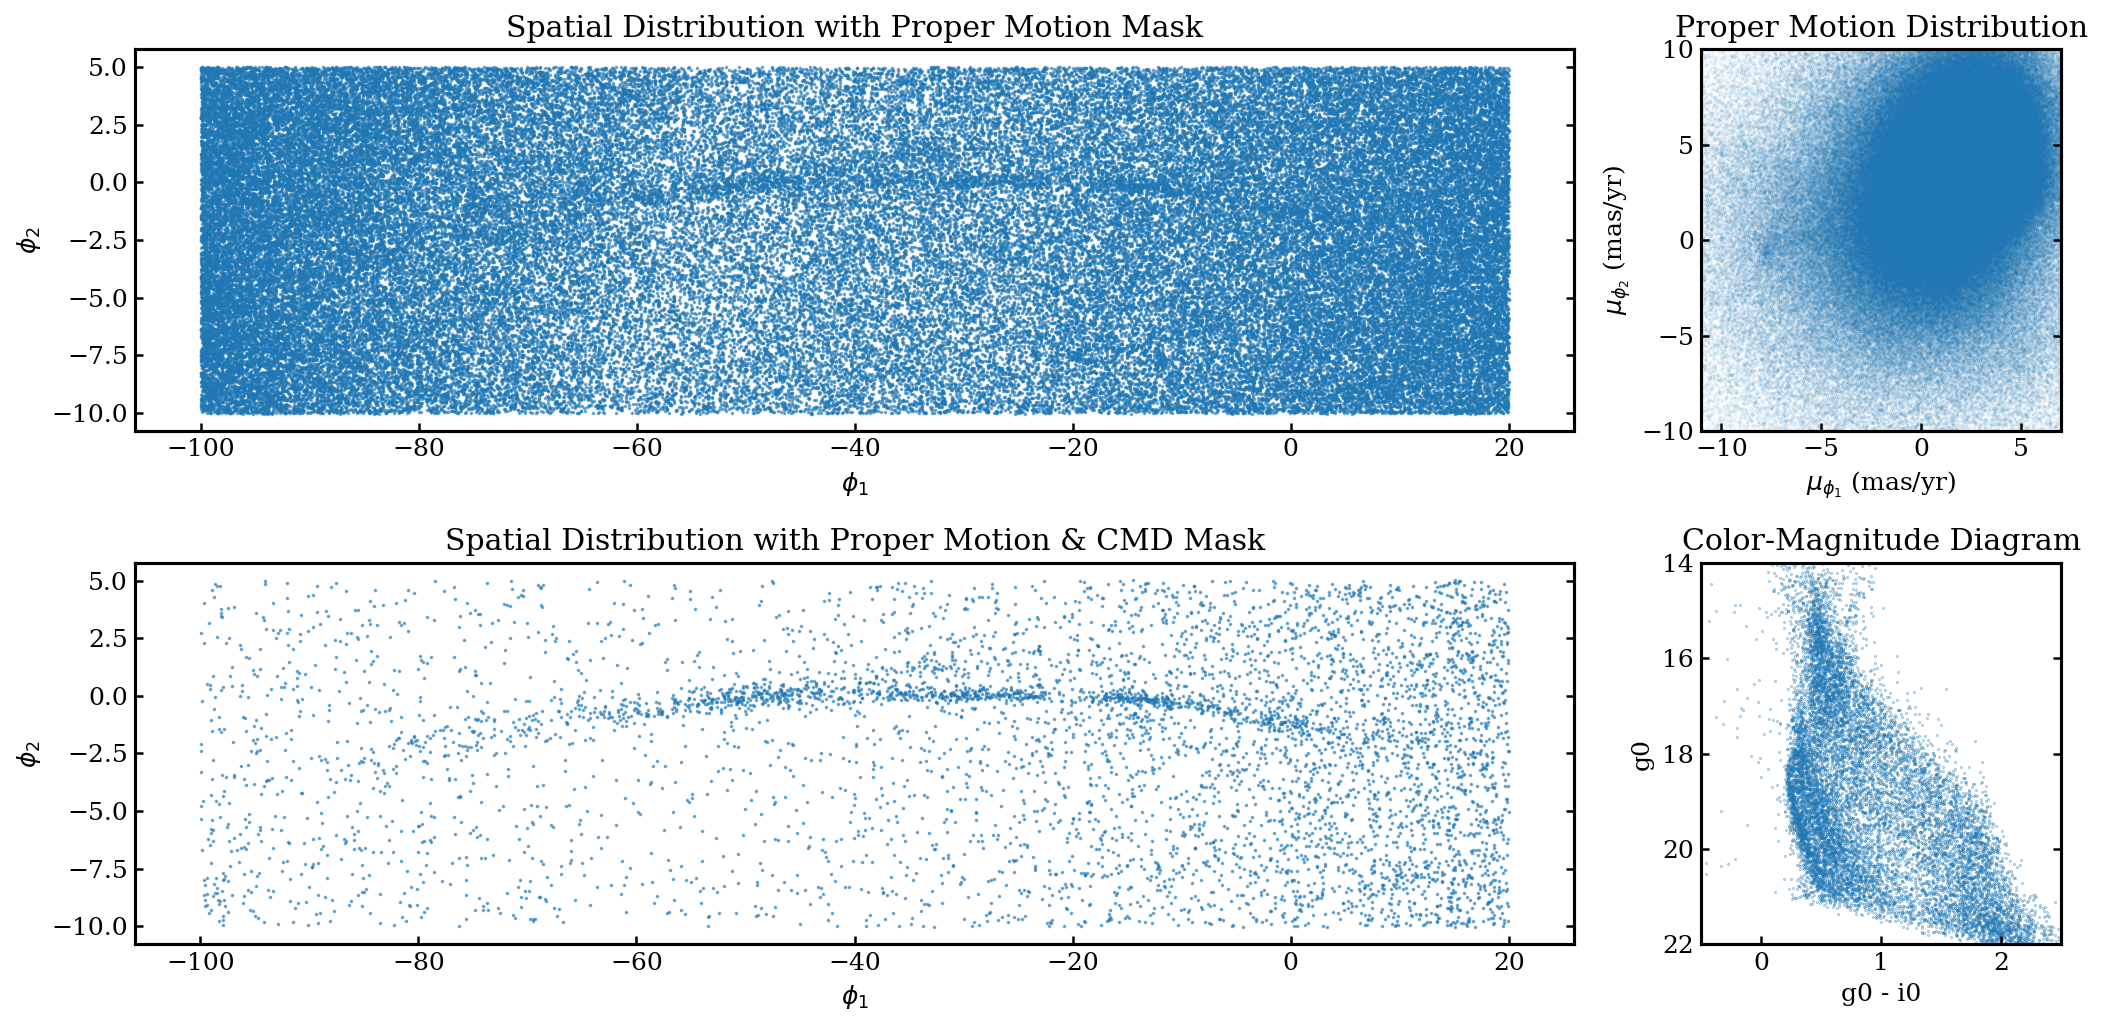

In [54]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Define the GridSpec layout
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1])

fig = plt.figure(figsize=(14, 7)) # Adjust the total figure size if necessary

# Top-left: Spatial distribution using only proper motion mask
filtered_data = gd1_data[gd1_data['pm_mask']]
ax0 = plt.subplot(gs[0])
ax0.scatter(filtered_data['phi1'], filtered_data['phi2'], s=0.5, alpha=0.6)
ax0.set_xlabel(r'$\phi_1$')
ax0.set_ylabel(r'$\phi_2$')
ax0.set_title('Spatial Distribution with Proper Motion Mask')

# Top-right: Proper motion
filtered_data = gd1_data[(np.abs(gd1_data['phi2']) < 1.0)]
ax1 = plt.subplot(gs[1])
#h = ax1.hist2d(filtered_data['pm_phi1_cosphi2_no_reflex'], filtered_data['pm_phi2_no_reflex'], bins=100, cmap='viridis', norm=LogNorm(), range=[[-11, 7], [-10, 10]])
plt.scatter(filtered_data['pm_phi1_cosphi2_no_reflex'], filtered_data['pm_phi2_no_reflex'], s=0.03, alpha=0.2)
ax1.set_xlabel('$\mu_{\phi_1}$ (mas/yr)')
ax1.set_ylabel('$\mu_{\phi_2}$ (mas/yr)')
ax1.set_title('Proper Motion Distribution')
ax1.set_xlim(-11, 7)
ax1.set_ylim(-10, 10)

# Bottom-left: Spatial distribution using proper motion and CMD masks
filtered_data = gd1_data[gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']]
ax2 = plt.subplot(gs[2])
ax2.scatter(filtered_data['phi1'], filtered_data['phi2'], s=0.5, alpha=0.6)
ax2.set_xlabel(r'$\phi_1$')
ax2.set_ylabel(r'$\phi_2$')
ax2.set_title('Spatial Distribution with Proper Motion & CMD Mask')

# Bottom-right: Color-magnitude diagram
filtered_data = gd1_data[(np.abs(gd1_data['phi2']) < 1.0) & (gd1_data['pm_mask'])]
ax3 = plt.subplot(gs[3])
ax3.scatter(filtered_data['g0'] - filtered_data['i0'], filtered_data['g0'], s=0.1, alpha=0.6)
ax3.set_xlabel('g0 - i0')
ax3.set_ylabel('g0')
ax3.set_title('Color-Magnitude Diagram')
ax3.invert_yaxis()
ax3.set_xlim(-0.5, 2.5)
ax3.set_ylim(22, 14)

plt.tight_layout()
plt.show()


In [6]:
# Converting to l, b
# Create a SkyCoord object from RA and Dec
coords = SkyCoord(ra=gd1_data['ra']*u.degree, dec=gd1_data['dec']*u.degree, frame='icrs')  # 'icrs' is the equatorial frame

# Convert to Galactic l and b
l = coords.galactic.l.deg  # Galactic longitude in degrees
b = coords.galactic.b.deg  # Galactic latitude in degrees

# Add to your data (if needed)
gd1_data['l'] = l
gd1_data['b'] = b
gd1_data['cosl'] = np.cos(np.deg2rad(l))
gd1_data['sinl'] = np.sin(np.deg2rad(l))

In [7]:
# Converting to galactocentric coordinates x, y, z
# Calculate the distance from parallax (with caution)
parallax_mas = gd1_data['parallax']  # Parallax in milliarcseconds (mas)
distance_kpc = (1.0 / parallax_mas)  # Distance in kpc

# Handle small or negative parallax values
# For this example, we'll mask them as NaN. You can handle them differently if needed.
#distance_kpc[parallax_mas <= 0] = np.nan

# Calculate distance with a precaution for very small parallaxes
small_parallax_threshold = 0.01  # mas, you can adjust this based on your dataset
max_distance_kpc = 100  # kpc, you can adjust this based on your dataset

distance_kpc[gd1_data['parallax'] <= small_parallax_threshold] = max_distance_kpc

# calculate distance with procedure from 1805.00425
# comment out this line if you want to just use parallax
distance_kpc = 0.05 * gd1_data['phi1'] + 10

# saving the distance as a new column
gd1_data['distance'] = distance_kpc


# Create a SkyCoord object from RA, Dec, and derived distance
coords = SkyCoord(ra=gd1_data['ra']*u.degree, 
                  dec=gd1_data['dec']*u.degree, 
                  distance=distance_kpc*u.kpc, 
                  frame='icrs')

# Convert to Galactic Cartesian coordinates
cartesian_coords = coords.transform_to('galactic').represent_as(CartesianRepresentation)
#print(Galactocentric())

# Extract x, y, z
x = cartesian_coords.x.value
y = cartesian_coords.y.value
z = cartesian_coords.z.value

# Add to your data (if needed)
gd1_data['x'] = x
gd1_data['y'] = y
gd1_data['z'] = z

#  mean and standard deviation of your x, y, and z values, as well as the mean and standard deviation of the parallax values
print(f'x: mean = {np.mean(gd1_data["x"]):.3f}, std = {np.std(gd1_data["x"]):.3f}')
print(f'y: mean = {np.mean(gd1_data["y"]):.3f}, std = {np.std(gd1_data["y"]):.3f}')
print(f'z: mean = {np.mean(gd1_data["z"]):.3f}, std = {np.std(gd1_data["z"]):.3f}')
print(f'parallax: mean = {np.mean(gd1_data["parallax"]):.3f}, std = {np.std(gd1_data["parallax"]):.3f}')


x: mean = -3.374, std = 0.963
y: mean = -2.596, std = 2.973
z: mean = 2.608, std = 2.682
parallax: mean = 0.186, std = 0.696


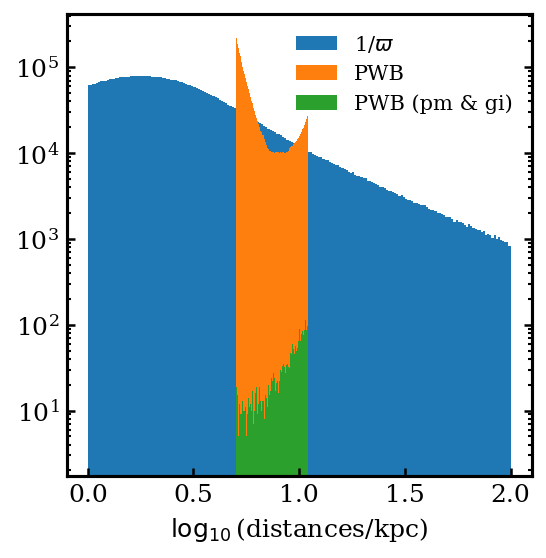

In [12]:
# Plotting a histogram of distance values with 1/parallax and with the PWB prescription and comparing
#### NOTE: THE PWB prescription gives a better distribution of distances than 1/parallax. 1/parallax is pretty bad...

nbins = 200

plt.figure(figsize=(4,4))
plt.hist(np.log10(1./gd1_data['parallax'][gd1_data['parallax'] > 0.01]),bins=nbins,label=r'1/$\varpi$',log=True)
#plt.hist(np.log10(1./gd1_data['parallax_error'][gd1_data['parallax'] > 0.01]),bins=nbins,label=r'1/$\sigma_\varpi$',log=True)
plt.hist(np.log10(gd1_data['distance']),bins=nbins,label=r'PWB',log=True)
# histogram of distances which pass the pm and gi cuts
plt.hist(np.log10(gd1_data['distance'][gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']]),bins=nbins,label=r'PWB (pm & gi)',log=True)
plt.xlabel(r'$\log_{10}$(distances/kpc)')
plt.legend(loc='best')
plt.show()

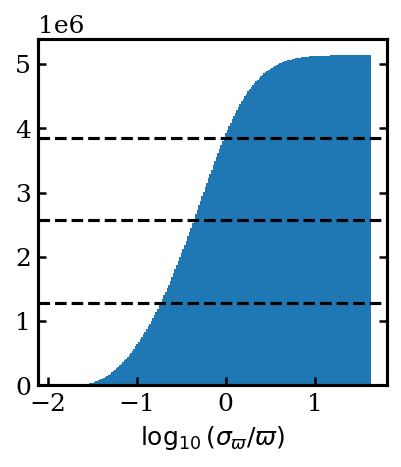

In [13]:
# Plotting parallax error/parallax

plt.figure(figsize=(3,3))
plt.hist(np.log10(gd1_data['parallax_error'][gd1_data['parallax']>0.1]/gd1_data['parallax'][gd1_data['parallax']>0.1]),bins=nbins,log=False,cumulative=True,label='parallax')
# show the percentiles for the cumulative distribution
for p in [0.25,0.5,0.75]:
    plt.axhline(p*len(gd1_data['parallax_error'][gd1_data['parallax']>0.1]),ls='--',color='k',label=f'{p*100:.0f}th percentile')

#plt.plot(gd1_data['parallax'][gd1_data['parallax']>0.1],gd1_data['parallax_error'][gd1_data['parallax']>0.1],'.',alpha=0.1,markersize=.05)
#plt.hist(gd1_data['parallax_error'],bins=nbins,log=True)
#plt.xlabel(r'$\log_{10}(\sigma_\varpi/\varpi)$')
#plt.xscale('log'); plt.yscale('log')
#plt.legend(loc='best')
plt.xlabel(r'$\log_{10}(\sigma_\varpi/\varpi)$')
plt.show()

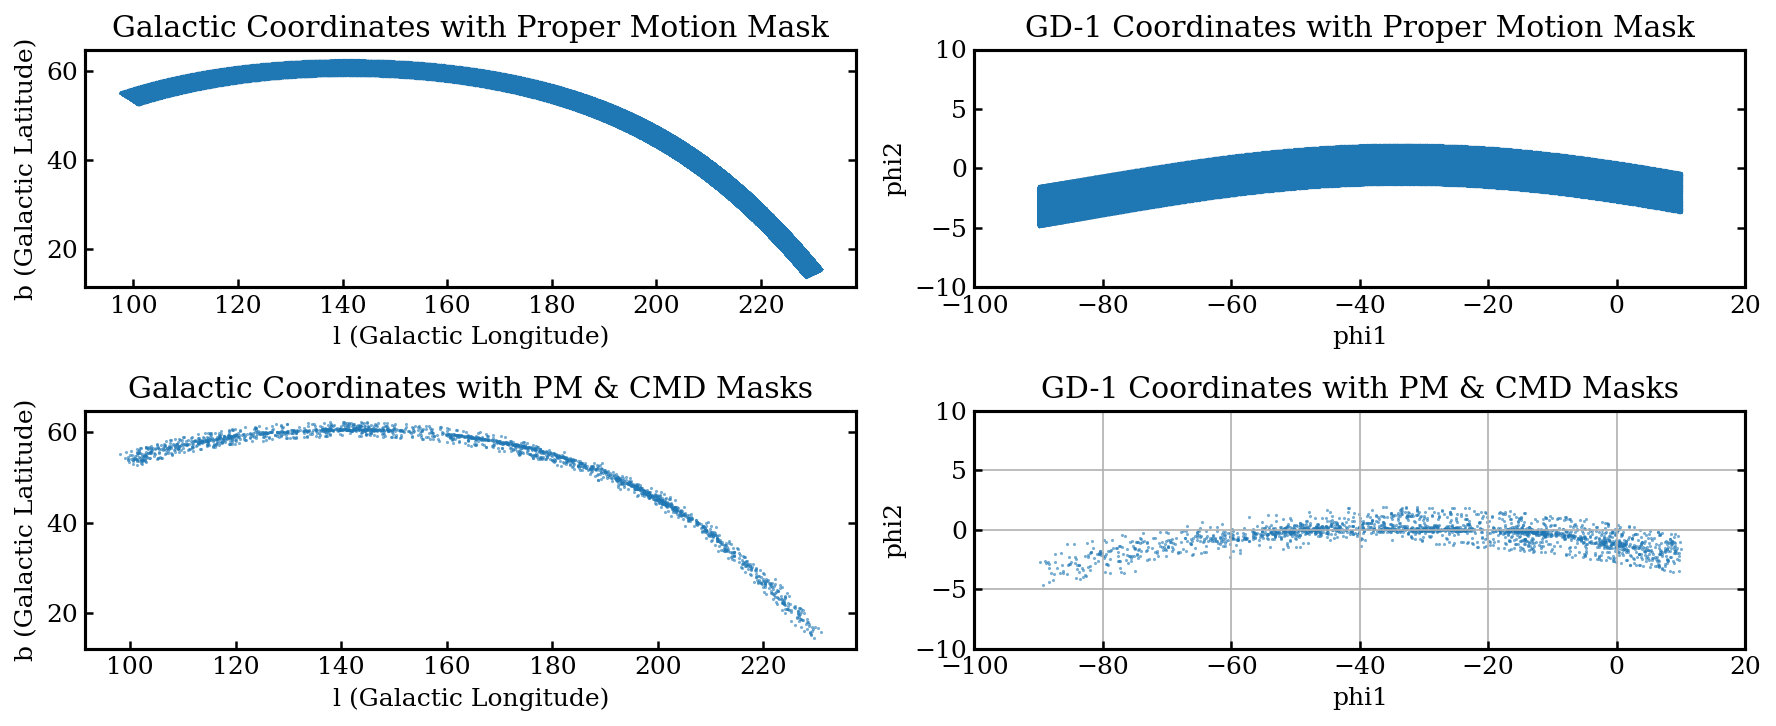

In [10]:
# Setup the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(12, 5))

phi1lims = [-100, 20]
phi2lims = [-10, 10]

# Top row: Using pm_mask
#filtered_data_pm = gd1_data[gd1_data['pm_mask']]
filtered_data_pm = gd1_data[gd1_data['stream_track_mask']]

# Top-left: l, b with pm_mask
axes[0, 0].scatter(filtered_data_pm['l'], filtered_data_pm['b'], s=0.25, alpha=0.6)
axes[0, 0].set_xlabel('l (Galactic Longitude)')
axes[0, 0].set_ylabel('b (Galactic Latitude)')
axes[0, 0].set_title('Galactic Coordinates with Proper Motion Mask')

# Top-right: phi1, phi2 with pm_mask
axes[0, 1].scatter(filtered_data_pm['phi1'], filtered_data_pm['phi2'], s=0.25, alpha=0.6)
axes[0, 1].set_xlabel('phi1')
axes[0, 1].set_ylabel('phi2')
axes[0, 1].set_title('GD-1 Coordinates with Proper Motion Mask')
axes[0, 1].set_xlim(phi1lims)
axes[0, 1].set_ylim(phi2lims)

# Bottom row: Using pm_mask & gi_cmd_mask
#filtered_data_pm_gi = gd1_data[gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']]
#filtered_data_pm_gi = gd1_data[gd1_data['stream_track_mask']]
filtered_data_pm_gi = gd1_data[gd1_data['pm_mask'] & gd1_data['gi_cmd_mask'] & gd1_data['stream_track_mask']]
#filtered_data_pm_gi = gd1_data[gd1_data['pm_mask'] & gd1_data['gi_cmd_mask'] & (np.abs(gd1_data['phi2']) < .5)]

# Bottom-left: l, b with pm_mask & gi_cmd_mask
axes[1, 0].scatter(filtered_data_pm_gi['l'], filtered_data_pm_gi['b'], s=0.25, alpha=0.6)
axes[1, 0].set_xlabel('l (Galactic Longitude)')
axes[1, 0].set_ylabel('b (Galactic Latitude)')
axes[1, 0].set_title('Galactic Coordinates with PM & CMD Masks')

# Bottom-right: phi1, phi2 with pm_mask & gi_cmd_mask
axes[1, 1].scatter(filtered_data_pm_gi['phi1'], filtered_data_pm_gi['phi2'], s=0.25, alpha=0.6)
axes[1, 1].set_xlabel('phi1')
axes[1, 1].set_ylabel('phi2')
axes[1, 1].set_title('GD-1 Coordinates with PM & CMD Masks')
axes[1, 1].set_xlim(phi1lims)
axes[1, 1].set_ylim(phi2lims)
axes[1, 1].grid(True)

# Adjust layout for clarity
plt.tight_layout()
plt.show()


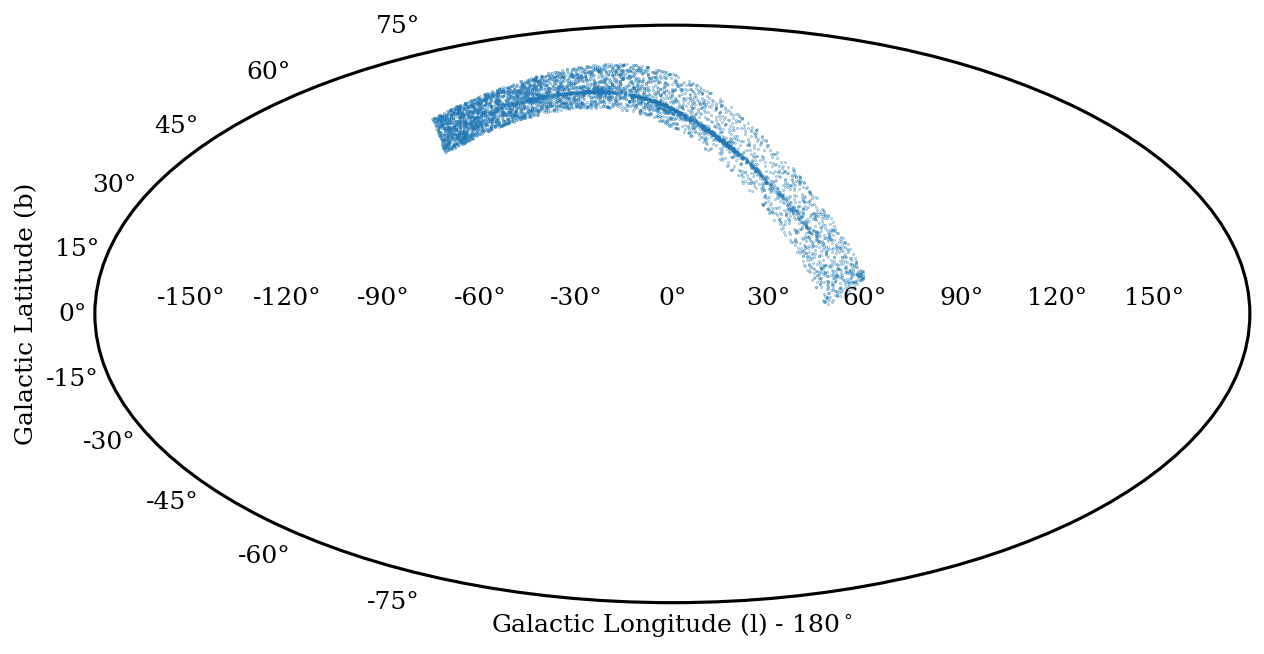

In [9]:
# Generate some random l and b values for illustration
l = np.random.uniform(0, 360, 1000)  # l values between 0 and 360 degrees
b = np.random.uniform(-90, 90, 1000)  # b values between -90 and 90 degrees

# Convert to radians
#l_rad = np.radians(l)
#b_rad = np.radians(b)
l_rad = np.deg2rad(l)
b_rad = np.deg2rad(b)

# Adjust l values to be in the range [-pi, pi] rather than [0, 2*pi]
l_rad = l_rad - np.pi

# l and b values 
filtered_data = gd1_data[gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']]
#filtered_data = gd1_data[(np.abs(gd1_data['phi2']) < 1.0) & (gd1_data['pm_mask']) & (gd1_data['gi_cmd_mask'])]
#print(filtered_data['l'].min(), filtered_data['l'].max())
#print(filtered_data['b'].min(), filtered_data['b'].max())

# Set up the Mollweide projection plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='mollweide')

# Plot the l, b values
#ax.scatter(l_rad, b_rad, s=1, alpha=0.6)
ax.scatter(np.radians(filtered_data['l'])-np.pi, np.radians(filtered_data['b']), s=.1, alpha=0.6)

# Set labels and title
ax.set_xlabel(r'Galactic Longitude (l) - 180$^\circ$')
ax.set_ylabel('Galactic Latitude (b)')
#ax.grid(True)
#ax.set_title('Star distribution in Galactic Coordinates')

plt.show()



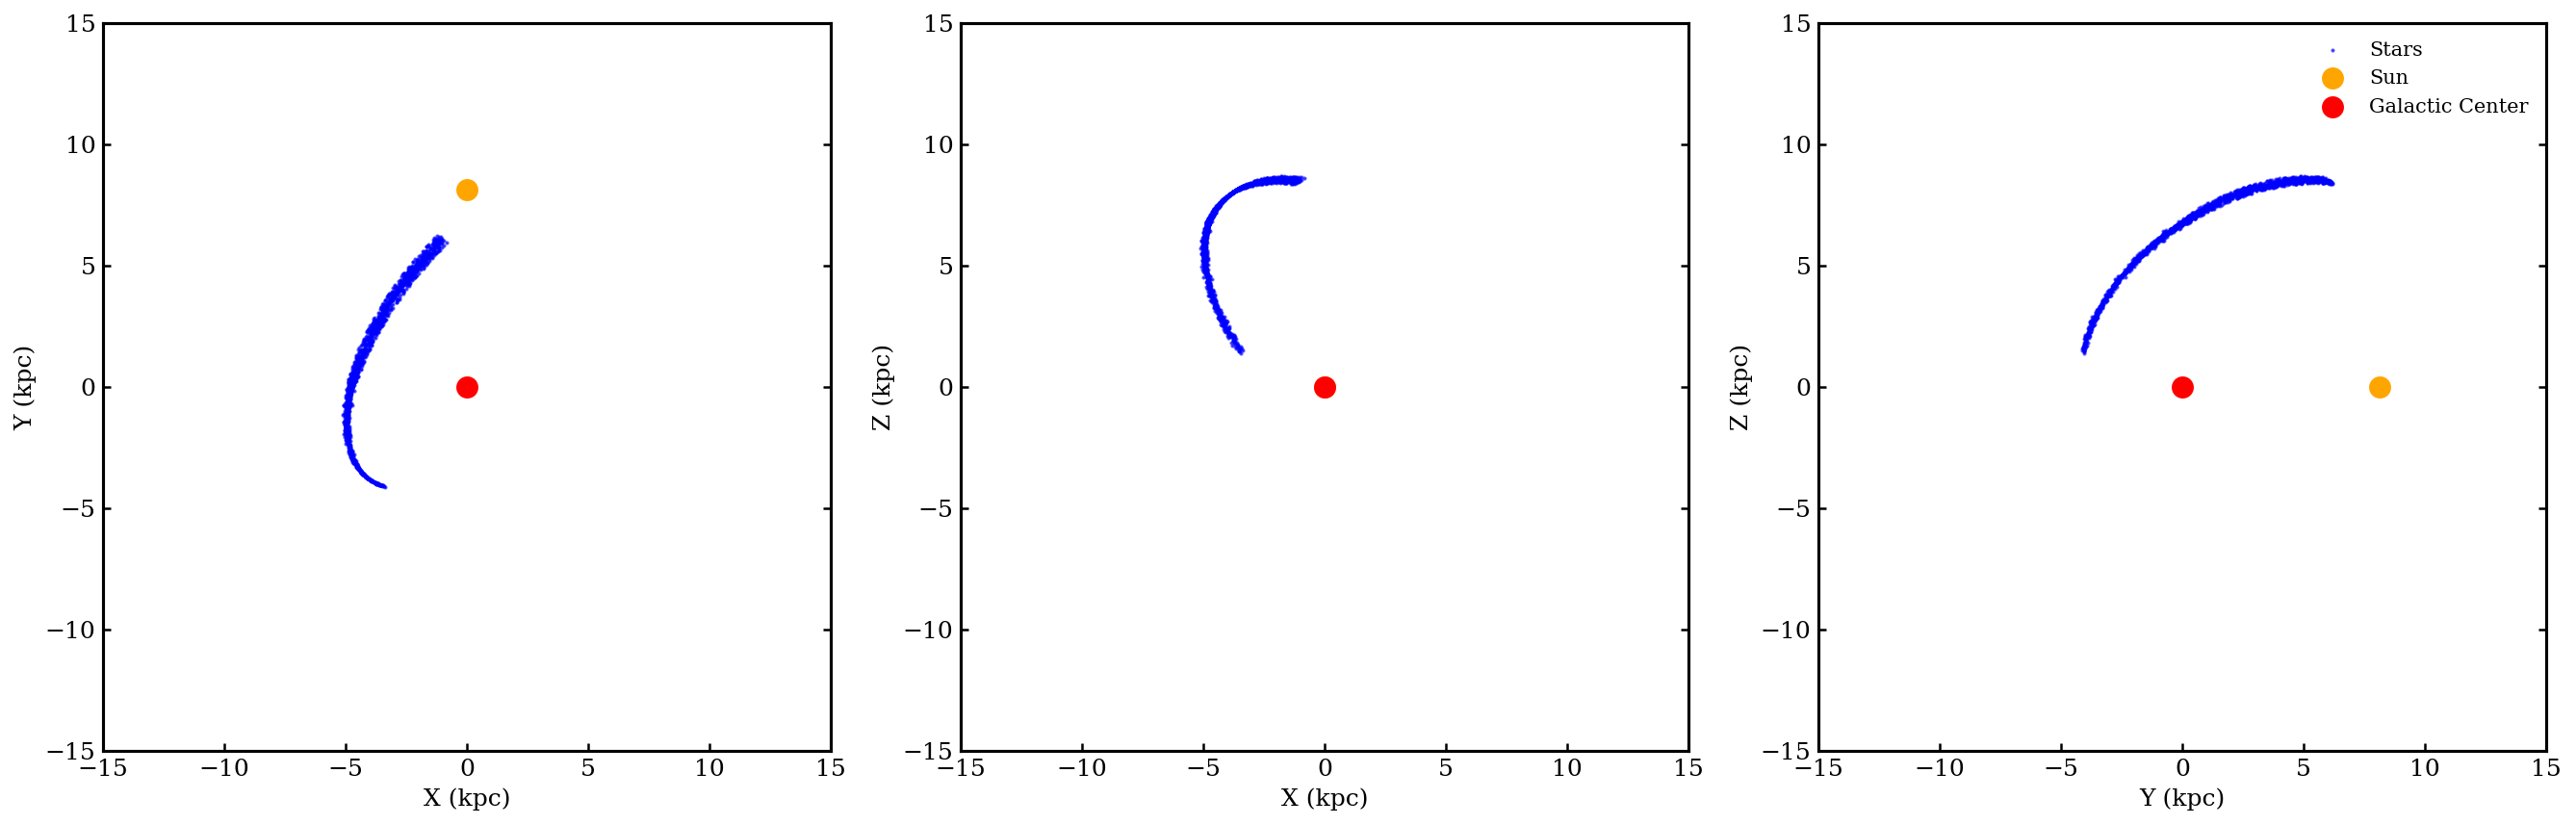

In [8]:
# Define the distance limits
limit_kpc = 1000  # kpc

# Filter data using combined pm_mask & gi_cmd_mask and distance restrictions

filtered_data = gd1_data[
#    :
    (gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']) &
    (np.abs(gd1_data['x']) <= limit_kpc) & 
    (np.abs(gd1_data['y']) <= limit_kpc) & 
    (np.abs(gd1_data['z']) <= limit_kpc)
    & gd1_data['stream_track_mask']
#    & (np.abs(gd1_data['phi2']) < 1.0)
#   & (-20 < gd1_data['phi1']) & (gd1_data['phi1'] < 0)
]

#filtered_data = gd1_data[
#    :
#]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Define consistent axis limits for all plots
axis_limit = [-15, 15]

# X-Y plot
axes[0].scatter(filtered_data['x'], filtered_data['y'], s=1, alpha=0.6, c='blue', label='Stars')
axes[0].scatter(0, 8.122, c='orange', s=100, marker='o', label='Sun')
axes[0].scatter(0, 0, c='red', s=100, marker='o', label='Galactic Center')
axes[0].set_xlim(axis_limit)
axes[0].set_ylim(axis_limit)
axes[0].set_xlabel('X (kpc)')
axes[0].set_ylabel('Y (kpc)')
#axes[0].set_title('Galactic XY Plane')
axes[0].set_aspect('equal', 'box')

# X-Z plot
axes[1].scatter(filtered_data['x'], filtered_data['z'], s=1, alpha=0.6, c='blue', label='Stars')
axes[1].scatter(0, 0, c='orange', s=100, marker='o', label='Sun')
axes[1].scatter(0, 0, c='red', s=100, marker='o', label='Galactic Center')  # Z-coordinate is 0 for both Sun and Galactic Center
axes[1].set_xlim(axis_limit)
axes[1].set_ylim(axis_limit)
axes[1].set_xlabel('X (kpc)')
axes[1].set_ylabel('Z (kpc)')
#axes[1].set_title('Galactic XZ Plane')
axes[1].set_aspect('equal', 'box')

# Y-Z plot
axes[2].scatter(filtered_data['y'], filtered_data['z'], s=1, alpha=0.6, c='blue', label='Stars')
axes[2].scatter(8.122, 0, c='orange', s=100, marker='o', label='Sun')
axes[2].scatter(0, 0, c='red', s=100, marker='o', label='Galactic Center')  # Z-coordinate is 0 for both Sun and Galactic Center
axes[2].set_xlim(axis_limit)
axes[2].set_ylim(axis_limit)
axes[2].set_xlabel('Y (kpc)')
axes[2].set_ylabel('Z (kpc)')
#axes[2].set_title('Galactic YZ Plane')
axes[2].set_aspect('equal', 'box')
axes[2].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [9]:
# counting the number of stars in a generic cut on phi1 only
phi1_min = -20
phi1_max = -5

# filter the data between these ph1 values
phi1_mask = (gd1_data['phi1'] > phi1_min) & (gd1_data['phi1'] < phi1_max)
phi1_data = gd1_data[phi1_mask]

# counting the number of stars in this cut
print(f'Number of stars in phi1 range: {len(phi1_data)}')

Number of stars in phi1 range: 255681


## Training a GNN on the data

In [9]:
# Convert the Astropy table to a pandas DataFrame
gd1_data_df = gd1_data.to_pandas()

# List of boolean columns (adjust this list based on your dataset)
bool_columns = ['stream_track_mask', 'pm_mask', 'gi_cmd_mask']

# Separate the boolean and numeric data
bool_data = gd1_data_df[bool_columns]
numeric_data = gd1_data_df.drop(columns=bool_columns)

# Scale only the numeric data
SS = StandardScaler()
numeric_data_scaled = pd.DataFrame(SS.fit_transform(numeric_data), columns=numeric_data.columns)

# Merge the scaled numeric data with the boolean data
gd1_data_scaled = pd.concat([numeric_data_scaled, bool_data], axis=1)

print(gd1_data_scaled)


         source_id        ra       dec  parallax  parallax_error      pmra  \
0         0.076916  0.501361  0.789063  0.783874       -0.446288 -1.855925   
1         0.076916  0.496499  0.793599  0.440722       -0.463824 -0.526949   
2         0.055041  0.515664  0.802023  0.090188        1.917946  0.147233   
3         0.055041  0.517767  0.801936 -0.032692       -0.388999  0.396185   
4         0.076895  0.502588  0.795155  0.532071       -0.506862 -0.534125   
...            ...       ...       ...       ...             ...       ...   
7248417   2.082055  1.960415  2.491297  0.935792       -0.753903  0.889641   
7248418   2.082076  1.948625  2.496546  0.190051        0.187816 -3.678397   
7248419   2.038433  1.929345  2.485132 -0.844463        0.617363  0.463720   
7248420   2.038369  1.969321  2.464180 -4.610955        1.940104 -1.146550   
7248421   2.082034  1.983101  2.476925  0.308759       -0.659673  0.645069   

         pmra_error     pmdec  pmdec_error  ra_parallax_corr  .

In [10]:
# defining the scaled training, validation, and testing data

training_phi1_min = -40; training_phi1_max = 5
validation_phi1_min = -60; validation_phi1_max = -40
testing_phi1_min = -100; testing_phi1_max = -60

phi2_lim = 2
undersample_background = False
target_to_background_factor = 50

# Filter the data between these phi1 values and randomly select 1000 stars from each set
np.random.seed(43)
#training_mask = (gd1_data['phi1'] > training_phi1_min) & (gd1_data['phi1'] < training_phi1_max)
training_mask = (gd1_data['phi1'] > training_phi1_min) & (gd1_data['phi1'] < training_phi1_max) & (gd1_data['stream_track_mask'])
#training_mask = (gd1_data['phi1'] > training_phi1_min) & (gd1_data['phi1'] < training_phi1_max) & (np.abs(gd1_data['phi2']) < phi2_lim)
training_indices = np.where(training_mask)[0]
print(f'training dataset size: {np.sum(training_mask)}')
training_indices_selected = np.random.choice(training_indices, np.sum(training_mask), replace=False)
# select indices such that the target stars are all included but the background stars are undersampled
if undersample_background:
    training_stream_stars = training_mask & gd1_data['stream_track_mask'] & gd1_data['pm_mask'] & gd1_data['gi_cmd_mask']
    training_background_stars = training_mask & ~(gd1_data['stream_track_mask'] & gd1_data['pm_mask'] & gd1_data['gi_cmd_mask'])
    training_stream_indices = np.where(training_stream_stars)[0]
    training_background_indices = np.where(training_background_stars)[0]
    #training_background_indices_selected = np.random.choice(training_background_indices, np.sum(training_stream_stars), replace=False)
    training_background_indices_selected = np.random.choice(training_background_indices, target_to_background_factor*np.sum(training_stream_stars), replace=False)
    training_indices_selected = np.concatenate((training_stream_indices,training_background_indices_selected))
    print(f'training dataset size after undersampling background: {len(training_indices_selected)}')

#validation_mask = (gd1_data['phi1'] > validation_phi1_min) & (gd1_data['phi1'] < validation_phi1_max)
validation_mask = (gd1_data['phi1'] > validation_phi1_min) & (gd1_data['phi1'] < validation_phi1_max) & (gd1_data['stream_track_mask'])
#validation_mask = (gd1_data['phi1'] > validation_phi1_min) & (gd1_data['phi1'] < validation_phi1_max) & (np.abs(gd1_data['phi2']) < phi2_lim)
validation_indices = np.where(validation_mask)[0]
print(f'validation dataset size: {np.sum(validation_mask)}')
validation_indices_selected = np.random.choice(validation_indices, np.sum(validation_mask), replace=False)

#testing_mask = (gd1_data['phi1'] > testing_phi1_min) & (gd1_data['phi1'] < testing_phi1_max)
testing_mask = (gd1_data['phi1'] > testing_phi1_min) & (gd1_data['phi1'] < testing_phi1_max) & (gd1_data['stream_track_mask'])
#testing_mask = (gd1_data['phi1'] > testing_phi1_min) & (gd1_data['phi1'] < testing_phi1_max) & (np.abs(gd1_data['phi2']) < phi2_lim)
testing_indices = np.where(testing_mask)[0]
print(f'testing dataset size: {np.sum(testing_mask)}')
testing_indices_selected = np.random.choice(testing_indices, np.sum(testing_mask), replace=False)

training_data_scaled = gd1_data_scaled.iloc[training_indices_selected]
validation_data_scaled = gd1_data_scaled.iloc[validation_indices_selected]
testing_data_scaled = gd1_data_scaled.iloc[testing_indices_selected]

training dataset size: 170888
validation dataset size: 83512
testing dataset size: 454345


In [11]:
# checking how many training data points are in the stream track and pass the pm and gi cuts
print(f'Number of training stars total: {len(training_data_scaled["phi1"])}')
#print(f'Number of training stars in stream track: {np.sum(training_data_scaled["stream_track_mask"])}')
print(f'Number of training stars in stream track and pass pm and gi cuts: {np.sum((training_data_scaled["stream_track_mask"]) & (training_data_scaled["pm_mask"]) & (training_data_scaled["gi_cmd_mask"]))}')
print(f'Ratio of training stars in stream track and pass pm and gi cuts to all training stars: {np.sum((training_data_scaled["stream_track_mask"]) & (training_data_scaled["pm_mask"]) & (training_data_scaled["gi_cmd_mask"]))/len(training_data_scaled["phi1"])}')

# same for validation data
print(f'\nNumber of validation stars total: {len(validation_data_scaled["phi1"])}')
#print(f'Number of validation stars in stream track: {np.sum(validation_data_scaled["stream_track_mask"])}')
print(f'Number of validation stars in stream track and pass pm and gi cuts: {np.sum((validation_data_scaled["stream_track_mask"]) & (validation_data_scaled["pm_mask"]) & (validation_data_scaled["gi_cmd_mask"]))}')
print(f'Ratio of validation stars in stream track and pass pm and gi cuts to all validation stars: {np.sum((validation_data_scaled["stream_track_mask"]) & (validation_data_scaled["pm_mask"]) & (validation_data_scaled["gi_cmd_mask"]))/len(validation_data_scaled["phi1"])}')

# same for testing data
print(f'\nNumber of testing stars total: {len(testing_data_scaled["phi1"])}')
#print(f'Number of testing stars in stream track: {np.sum(testing_data_scaled["stream_track_mask"])}')
print(f'Number of testing stars in stream track and pass pm and gi cuts: {np.sum((testing_data_scaled["stream_track_mask"]) & (testing_data_scaled["pm_mask"]) & (testing_data_scaled["gi_cmd_mask"]))}')
print(f'Ratio of testing stars in stream track and pass pm and gi cuts to all testing stars: {np.sum((testing_data_scaled["stream_track_mask"]) & (testing_data_scaled["pm_mask"]) & (testing_data_scaled["gi_cmd_mask"]))/len(testing_data_scaled["phi1"])}')


Number of training stars total: 170888
Number of training stars in stream track and pass pm and gi cuts: 1198
Ratio of training stars in stream track and pass pm and gi cuts to all training stars: 0.007010439586161697

Number of validation stars total: 83512
Number of validation stars in stream track and pass pm and gi cuts: 408
Ratio of validation stars in stream track and pass pm and gi cuts to all validation stars: 0.004885525433470639

Number of testing stars total: 454345
Number of testing stars in stream track and pass pm and gi cuts: 266
Ratio of testing stars in stream track and pass pm and gi cuts to all testing stars: 0.0005854581870604937


In [12]:
# defining and testing a chunked cdist function
# it will ideally ease up the RAM requirements for computing distances amongst the stars

def chunked_cdist(A, B, chunk_size=1000):
    # Create a placeholder for the result
    result = torch.empty((A.shape[0], B.shape[0]))

    # Split tensors A and B into chunks
    chunks_A = torch.split(A, chunk_size, dim=0)
    chunks_B = torch.split(B, chunk_size, dim=0)

    for i, chunk_A in enumerate(chunks_A):
        for j, chunk_B in enumerate(chunks_B):
            # Compute distances between the chunks
            dists = torch.tensor(cdist(chunk_A, chunk_B))
            
            # Store in the right slice of the result tensor
            result[i*chunk_size:(i+1)*chunk_size, j*chunk_size:(j+1)*chunk_size] = dists

            # Clear out the memory to avoid using up too much RAM
            del dists

    return result

N_random=10000
positions_random = torch.tensor(np.random.uniform(size=(N_random,3)))
time_start = time.time()
#distances_random = cdist(positions_random,positions_random)
distances_random = chunked_cdist(positions_random, positions_random)
time_end = time.time()
print(f'Time taken for {N_random} random positions to compute {distances_random.shape} distance matrix: {time_end-time_start:.3f} seconds')

Time taken for 10000 random positions to compute torch.Size([10000, 10000]) distance matrix: 0.258 seconds


In [13]:
# setting up the training, validation and testing graphs
# I will use the cdist with a cutoff to define the edges of the graph

# if normalised_distances_train is still there, delete it
try:
    del normalized_distances_train
except NameError:
    pass

# defining the cutoff
#cutoff = 1.0e-6 # basically zero, but allows some numerical error
cutoff = 0.005 # kpc

# defining the training graph
positions_train = torch.tensor(gd1_data[training_indices_selected]['x','y','z'],dtype=torch.float32)
print(positions_train.shape)
#distances_train = chunked_cdist(positions_train, positions_train)
#edges_train = torch.tensor(np.argwhere(distances_train <= cutoff),dtype=torch.long)
edges_train = radius_graph(positions_train, cutoff, batch=None, loop=True, max_num_neighbors=positions_train.shape[0])
# Calculating distances for each edge
# Assuming Euclidean distance; adjust if a different metric is needed
edge_distances_train = torch.sqrt(((positions_train[edges_train[0]] - positions_train[edges_train[1]]) ** 2).sum(dim=1))
mean_distance_train = edge_distances_train.mean()
max_distance_train = edge_distances_train.max()
edge_distances_train.div_(max_distance_train)
print(f'Done calculating distances')

# Normalizing the distances
#min_distance = distances_train.min() # redundant since the minimum distance is zero
#max_distance = distances_train.max()
#mean_distance = distances_train.mean()
#device = torch.device('mps')
#normalized_distances_train = distances_train.clone().div_(max_distance)
# Extracting the distances corresponding to the edges
#edge_distances = (normalized_distances_train[edges_train[0, :], edges_train[1, :]])
#print(f'Done normalizing distances')

#deg = degree(data.edge_index[0], num_nodes=x_norm.size(0))
deg_train = degree(edges_train[0], num_nodes=positions_train.size(0))

features = ['cosl','sinl','b','distance','pmra','pmdec']
input_train = torch.tensor(training_data_scaled[features].values,dtype=torch.float32)
#input_train = np.array([(training_data_scaled['cosl']),training_data_scaled['sinl'],training_data_scaled['b'],training_data_scaled['distance'],training_data_scaled['pmra'],training_data_scaled['pmdec']]).T
output_train = np.array(training_data_scaled['stream_track_mask'] & training_data_scaled['pm_mask'] & training_data_scaled['gi_cmd_mask']).T
graph_train = Data(x=torch.tensor(input_train,dtype=torch.float),edge_index=edges_train,y=torch.tensor(output_train,dtype=torch.float)
                   ,edge_attr=edge_distances_train
#                    ,edge_attr=None 
                    )
graph_train.deg = deg_train

print(input_train.shape)
print(output_train.shape)
print(np.sum(output_train))
print(edges_train.shape)
print(edges_train.shape)
print(graph_train.edge_index.shape)


torch.Size([170888, 3])
Done calculating distances
torch.Size([170888, 6])
(170888,)
1198
torch.Size([2, 755470])
torch.Size([2, 755470])
torch.Size([2, 755470])


/var/folders/j6/7fyxf3x9101dhdpxqkfps69w0000gn/T/ipykernel_50431/2806691129.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph_train = Data(x=torch.tensor(input_train,dtype=torch.float),edge_index=edges_train,y=torch.tensor(output_train,dtype=torch.float)


In [14]:
print(graph_train.x.shape)
print(graph_train.edge_index.shape)
print(graph_train.edge_attr.shape)
print(graph_train.deg.shape)

torch.Size([170888, 6])
torch.Size([2, 755470])
torch.Size([755470])
torch.Size([170888])


In [58]:
''' This can crash if the graph is too big'''
# Histogram of distances in the training graph

'''# Get the upper triangular indices (excluding diagonal)
upper_tri_indices = torch.triu_indices(distances_train.size(0), distances_train.size(1), offset=1)

# Extract the unique distances using the indices
unique_distances = distances_train[upper_tri_indices[0], upper_tri_indices[1]]

# randomly sample the unique distances
unique_distances_random = unique_distances[np.random.choice(len(unique_distances),size=1000,replace=False)]

# Now, plot the histogram:
plt.figure(figsize=(4,4))
plt.hist(unique_distances_random, bins=100, log=True)
plt.xlabel('distance/kpc')
plt.show()'''

"# Get the upper triangular indices (excluding diagonal)\nupper_tri_indices = torch.triu_indices(distances_train.size(0), distances_train.size(1), offset=1)\n\n# Extract the unique distances using the indices\nunique_distances = distances_train[upper_tri_indices[0], upper_tri_indices[1]]\n\n# randomly sample the unique distances\nunique_distances_random = unique_distances[np.random.choice(len(unique_distances),size=1000,replace=False)]\n\n# Now, plot the histogram:\nplt.figure(figsize=(4,4))\nplt.hist(unique_distances_random, bins=100, log=True)\nplt.xlabel('distance/kpc')\nplt.show()"

In [15]:
# defining the validation graph
positions_val = torch.tensor(gd1_data[validation_indices_selected]['x','y','z'],dtype=torch.float32)
print(positions_val.shape)
#distances_val = chunked_cdist(positions_val,positions_val)
#edges_val = torch.tensor(np.argwhere(distances_val < cutoff),dtype=torch.long)
edges_val = radius_graph(positions_val, cutoff, batch=None, loop=True, max_num_neighbors=positions_val.shape[0])
# Calculating distances for each edge
# Assuming Euclidean distance; adjust if a different metric is needed
edge_distances_val = torch.sqrt(((positions_val[edges_val[0]] - positions_val[edges_val[1]]) ** 2).sum(dim=1))
#mean_distance_val = edge_distances_val.mean()
#max_distance_val = edge_distances_val.max()
edge_distances_val.div_(max_distance_train)
print(f'Done calculating distances')
print(edges_val.shape)
deg_val = degree(edges_val[0], num_nodes=positions_val.size(0))
input_val = torch.tensor(validation_data_scaled[features].values,dtype=torch.float32)
#input_val = np.array([(validation_data_scaled['cosl']),validation_data_scaled['sinl'],validation_data_scaled['b'],validation_data_scaled['distance'],validation_data_scaled['pmra'],validation_data_scaled['pmdec']]).T
output_val = np.array(validation_data_scaled['stream_track_mask'] & validation_data_scaled['pm_mask'] & validation_data_scaled['gi_cmd_mask']).T
graph_val = Data(x=torch.tensor(input_val,dtype=torch.float),edge_index=edges_val,y=torch.tensor(output_val,dtype=torch.float)
                 ,edge_attr=edge_distances_val
                 )
graph_val.deg = deg_val

'''
# defining the testing graph
positions_test = torch.tensor(gd1_data[testing_indices_selected]['x','y','z'])
print(positions_test.shape)
distances_test = cdist(positions_test,positions_test)

input_test = np.array([(testing_data_scaled['cosl']),testing_data_scaled['sinl'],testing_data_scaled['b'],testing_data_scaled['distance'],testing_data_scaled['pmra'],testing_data_scaled['pmdec']]).T
output_test = np.array(testing_data_scaled['stream_track_mask'] & testing_data_scaled['pm_mask'] & testing_data_scaled['gi_cmd_mask']).T
'''

torch.Size([83512, 3])
Done calculating distances
torch.Size([2, 555770])


/var/folders/j6/7fyxf3x9101dhdpxqkfps69w0000gn/T/ipykernel_50431/4007868560.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  graph_val = Data(x=torch.tensor(input_val,dtype=torch.float),edge_index=edges_val,y=torch.tensor(output_val,dtype=torch.float)


"\n# defining the testing graph\npositions_test = torch.tensor(gd1_data[testing_indices_selected]['x','y','z'])\nprint(positions_test.shape)\ndistances_test = cdist(positions_test,positions_test)\n\ninput_test = np.array([(testing_data_scaled['cosl']),testing_data_scaled['sinl'],testing_data_scaled['b'],testing_data_scaled['distance'],testing_data_scaled['pmra'],testing_data_scaled['pmdec']]).T\noutput_test = np.array(testing_data_scaled['stream_track_mask'] & testing_data_scaled['pm_mask'] & testing_data_scaled['gi_cmd_mask']).T\n"

In [67]:
## Defining the interaction graph network model

class ResNet(nn.Module):
    """Fully connected NN w/ residual connections and Gaussian init
    Args:
    in_dim: input dimension
    out_dim: output dimension
    hidden_dim: width, hidden dimension
    alpha: strength of the residual connection
    L: depth, number of hidden layers
    Cw: variance scale for Gaussian init
    """

    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        hidden_dim: int,
        alpha: float = 0,
        L: int = 2,
        Cw: float = 2,
        dropout_rate: float = 0.,
    ):
        super(ResNet, self).__init__()

        self.layers = ModuleList()
        for layer in range(L + 1):
            self.layers.append(
                Linear(
                    in_dim if (layer == 0) else hidden_dim,
                    out_dim if (layer == L) else hidden_dim,
                    bias=False,
                )
            )

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim

        self.alpha = alpha
        self.L = L
        self.Cw = Cw
        self.relu = ReLU()
        self.dropout_rate = dropout_rate

        self.reset_parameters()

    def reset_parameters(self):
        for layer, weights in enumerate(self.layers):
            for p in weights.weight:
                std = math.sqrt(1.0 / self.in_dim)
                if layer > 0:
                    std = math.sqrt(self.Cw / self.hidden_dim)
                init.normal_(p.data, mean=0, std=std)
    
    def forward(self, x: Tensor):
        for layer, weights in enumerate(self.layers):
            if layer == 0:
                x = weights(x)
            elif (layer > 0) and (layer < self.L): # implement res property, rely and dropout
                x = self.alpha * x + weights(self.relu(x))
                #x = F.dropout(x, p=self.dropout_rate , training = self.training) #unexplored for GNN
            else:
                x = weights(self.relu(x))
        return x


class InteractionNetwork(MessagePassing):
    """Interaction network (IN) GNN layer
    Args:
    node_dims: dimension of node network, in the form
               {"in": in_dim, "hidden": hidden_dim, "out": out_dim}
    edge_dims: dimension of the edge network, in the form
               {"in": in_dim, "hidden": hidden_dim, "out": out_dim}
    L: depth of the ResNet node/edge networks
    alpha_node: res. connection strength in the node network
    alpha_edge: res. connection strength in the edge network
    Cw: variance scale for Gaussian init
    """

    def __init__(
        self,
        node_dims: int,
        edge_dims: int,
        L: int = 2,
        alpha_node: float = 0,
        alpha_edge: float = 0,
        Cw: float = 2.0,
        dropout_rate: float = 0.,
    ):
        super(InteractionNetwork, self).__init__(aggr="add")

        self.edge_net = ResNet(
            edge_dims["in"] + 2 * node_dims["in"],
            edge_dims["out"],
            edge_dims["hidden"],
            L=L,
            alpha=alpha_edge,
            Cw=Cw,
            dropout_rate=dropout_rate,
        )
        self.node_net = ResNet(
            node_dims["in"] + edge_dims["out"],
            node_dims["out"],
            node_dims["hidden"],
            L=L,
            alpha=alpha_node,
            Cw=Cw,
            dropout_rate=dropout_rate,
        )
        self.edge_attr = Tensor()

    def forward(
        self, x: Tensor, edge_index: Tensor, edge_attr: Tensor, deg: Tensor
    ) -> Tensor:
        # Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        #x = self.propagate(edge_index, x=x, edge_attr=edge_attr, deg=deg)
        x = self.propagate(edge_index, x=x, edge_attr=edge_attr, norm=norm)
        return x, self.edge_attr

    def message(self, x_i, x_j, edge_attr, norm):
        #m = torch.cat([x_i, x_j, edge_attr.unsqueeze(-1)], dim=1) * norm.view(-1, 1)
        #self.edge_attr = self.edge_net(m)
        # Check if edge_attr is 1D and reshape if necessary
        if edge_attr.dim() == 1:
            edge_attr = edge_attr.unsqueeze(-1)  # Reshapes from [N] to [N, 1]
        #print(x_i.shape, x_j.shape, edge_attr.unsqueeze(-1).shape, norm.view(-1,1).shape)
        m = torch.cat([x_i, x_j, edge_attr], dim=1) * norm.view(-1, 1)
        # Process through the edge network and flatten the output
        self.edge_attr = self.edge_net(m)

        return self.edge_attr

    def update(self, aggr_out, x):
        c = torch.cat([x, aggr_out], dim=1)
        return self.node_net(c)


class IGNN(nn.Module):
    """GNN based on repeated interaction network (IN) convolutions
    Args:
    node_dims: node dims at input, intermediate, and output layers:
               {"in": in_dim, "hidden": hidden_dim, "out": out}
    edge_dims: edge dims at input, intermediate, and output layers:
               {"in": in_dim, "hidden": hidden_dim, "out": out}
    L: depth of the GNN, i.e. the number of IN layers
    L_internal: depth of the fully-connected NNs in each IN layer
    width: width of the node/edge networks in each IN layer
    Cw: variance scale for Gaussian init
    alpha_node: res. connection strength in each IN node network
    alpha_edge: res. connection strength in each IN edge network
    beta_node: res. connection strength between IN layers (node feats)
    beta_edge: res. connection strength between IN layers (edge feats)
    """

    def __init__(
        self,
        node_dims: int,
        edge_dims: int,
        L: int = 3,
        L_internal: int = 3,
        width: int = 128,
        alpha_node: float = 0,
        alpha_edge: float = 0,
        beta_node: float = 0,
        beta_edge: float = 0,
        Cw: float = 2.0,
        dropout_rate: float = 0.,
    ):
        super(IGNN, self).__init__()

        self.layers = ModuleList()
        for layer in range(L + 1):
            l0 = layer == 0
            lL = layer == L
            self.layers.append(
                InteractionNetwork(
                    node_dims={
                        "in": node_dims["in"] if l0 else node_dims["hidden"],
                        "out": node_dims["out"] if lL else node_dims["hidden"],
                        "hidden": width,
                    },
                    edge_dims={
                        "in": edge_dims["in"] if l0 else edge_dims["hidden"],
                        "out": edge_dims["out"] if lL else edge_dims["hidden"],
                        "hidden": width,
                    },
                    L=L_internal,
                    Cw=Cw,
                    alpha_node=alpha_node,
                    alpha_edge=alpha_edge,
                    dropout_rate=dropout_rate,
                )
            )
            
        self.L = L
        self.L_internal = L_internal
        self.width = width
        self.beta_node = beta_node
        self.beta_edge = beta_edge
        self.relu = ReLU()
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index, edge_attr, deg = (
            data.x,
            data.edge_index,
            data.edge_attr,
            data.deg,
        )
        for layer, weights in enumerate(self.layers):
            x_new, edge_attr_new = weights(x, edge_index, edge_attr, deg)
            #x_new = x_new / x_new.pow(2).sum(1).sqrt().unsqueeze(1)
            #edge_attr_new = (
            #    edge_attr_new
            #    / edge_attr_new.pow(2).sum(1).sqrt().unsqueeze(1)
            #)
            if layer>0 and layer<self.L:
                x = self.beta_node * x + x_new
                edge_attr = self.beta_edge * edge_attr + edge_attr_new
                x = F.dropout(x, p=self.dropout_rate , training = self.training)

            else:
                x = x_new
                edge_attr = edge_attr_new
        return x, edge_attr

'''ignn = IGNN(
    node_dims={"in": data.x.shape[1], "out": 64, "hidden": 64},
    edge_dims={"in": 1, "out": 1, "hidden": 64}, 
    L_internal=6, L=10, width=128,
    alpha_node=0, alpha_edge=0, Cw=2, 
)
data["edge_attr"] = edge_attr 
x_out, edge_attr_out = ignn(data)
print(x_out.pow(2).sum(1).mean())'''

'ignn = IGNN(\n    node_dims={"in": data.x.shape[1], "out": 64, "hidden": 64},\n    edge_dims={"in": 1, "out": 1, "hidden": 64}, \n    L_internal=6, L=10, width=128,\n    alpha_node=0, alpha_edge=0, Cw=2, \n)\ndata["edge_attr"] = edge_attr \nx_out, edge_attr_out = ignn(data)\nprint(x_out.pow(2).sum(1).mean())'

In [77]:
# defining the network class

#define the gnn model
class GNNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, Kval = 3, dropout_rate = 0.5):
        super(GNNModel, self).__init__()
        # ChebConv network
        self.conv1 = ChebConv(input_dim, hidden_dim, K = Kval)
        self.conv2 = ChebConv(hidden_dim, hidden_dim, K = Kval)
        self.conv3 = ChebConv(hidden_dim, output_dim, K = Kval)
        # GCN Conv network
        #self.conv1 = GCNConv(input_dim, hidden_dim)
        #self.conv2 = GCNConv(hidden_dim, hidden_dim)
        #self.conv3 = GCNConv(hidden_dim, output_dim)
        #self.fc  = torch.nn.Linear(hidden_dim, output_dim)
        self.dropout_rate = dropout_rate

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply two GCN layers with relu activations
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate ,training = self.training) #unexplored for GNN
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, p=self.dropout_rate ,training = self.training) #unexplored for GNN
        x = self.conv3(x, edge_index)
        #x = F.dropout(x, training = self.training)
        ##x = self.fc(x) #GNN with no edge; removes edge information

        # Compute the mean across nodes in the graph
        #x = torch.mean(x, dim=0)
        #print(x)

        # Apply a linear transformation for regression
        #x = torch.nn.Linear(x.size()[0], 1)(x)
        #print('x',x.shape)

        return x #output and targets need same dimensionality 

# Set seeds for reproducibility
#random.random.seed(0)
np.random.seed(42)
torch.manual_seed(42)

# check the device for macbook MPS or cpu
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Device: {device}")

#initialize the model
#model = GNNModel(6,32,1).to(device)
IGNNbool = True
if IGNNbool:
    model = IGNN(
    node_dims={"in": len(features), "out": 1, "hidden": 32},
    edge_dims={"in": 1, "out": 16, "hidden": 32}, 
    L_internal=2, L=3, width=32,
    alpha_node=np.sqrt(0.), alpha_edge=np.sqrt(0.), Cw=2,
    beta_node=0., beta_edge=0.,
    dropout_rate=0.7,
).to(device)
else:
    model = GNNModel(len(features),32,1,dropout_rate=0.6).to(device)

graph_train = graph_train.to(device)
graph_val = graph_val.to(device)

print(f'graph train vertices: {graph_train.x.shape}, graph train edges: {graph_train.edge_index.shape}')

# print number of parameters
print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

#train the model
#optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1.0e-2)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-2)
pos_weight = torch.tensor([100]).to(device)  # adjust this value as required
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#criterion = torch.nn.MSELoss()

print(f'\nStarting Training...\n')

training_loss_history = []
validation_loss_history = []

time_start = time.time()
for epoch in range(150+1):
    model.train()
    optimizer.zero_grad()
    if IGNNbool:
        out, edge_attr_out = model(graph_train)
    else:
        out = model(graph_train)
    #print('out',out.shape)
    #print('data.y',data.y.unsqueeze(-1).shape)
    #loss = criterion(out, data.y.unsqueeze(-1))
    loss = criterion(out, graph_train.y.unsqueeze(-1))
    #print(loss)
    loss.backward()
    optimizer.step()

    # VALIDATION
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        
        if IGNNbool:
            out_train, edge_attr_out_train = model(graph_train)
            out_val, edge_attr_out_val = model(graph_val)
        else:
            out_train = model(graph_train)
            out_val = model(graph_val)
        #print(out_val.shape)
        loss_train = criterion(out_train, graph_train.y.unsqueeze(-1))
        loss_val = criterion(out_val, graph_val.y.unsqueeze(-1))

    # Saving the loss values for later plotting
    training_loss_history.append(loss_train.item())
    validation_loss_history.append(loss_val.item())

    if (epoch) % 10 == 0:
        print(out.mean())
        print(f'Epoch {epoch}, Train Loss: {loss_train.item()}, Val Loss: {loss_val.item()}')
        #print(f'Epoch {epoch}, Train Loss: {loss.item()}')
time_end = time.time()
print(f'Time taken for training: {time_end-time_start:.3f} seconds')
#Edge weights?
#GATConv doesn't take in an edge weight; it takes this into account for free
#pytorch lightning to early stop etc. 

Device: cpu
graph train vertices: torch.Size([170888, 6]), graph train edges: torch.Size([2, 755470])
Number of parameters: 31360

Starting Training...

tensor(1.4845, grad_fn=<MeanBackward0>)
Epoch 0, Train Loss: 1.3665523529052734, Val Loss: 1.1358458995819092
tensor(0.2399, grad_fn=<MeanBackward0>)
Epoch 10, Train Loss: 1.1746406555175781, Val Loss: 1.0171502828598022
tensor(-0.0108, grad_fn=<MeanBackward0>)
Epoch 20, Train Loss: 1.1542338132858276, Val Loss: 1.0096567869186401
tensor(-0.1130, grad_fn=<MeanBackward0>)
Epoch 30, Train Loss: 1.1484254598617554, Val Loss: 1.0023201704025269
tensor(-0.1933, grad_fn=<MeanBackward0>)
Epoch 40, Train Loss: 1.1372032165527344, Val Loss: 0.9951337575912476
tensor(-0.3375, grad_fn=<MeanBackward0>)
Epoch 50, Train Loss: 1.1150041818618774, Val Loss: 0.9757122993469238
tensor(-0.5006, grad_fn=<MeanBackward0>)
Epoch 60, Train Loss: 1.0803016424179077, Val Loss: 0.9440368413925171
tensor(-0.7032, grad_fn=<MeanBackward0>)
Epoch 70, Train Loss: 1.0

(0.1, 10.0)

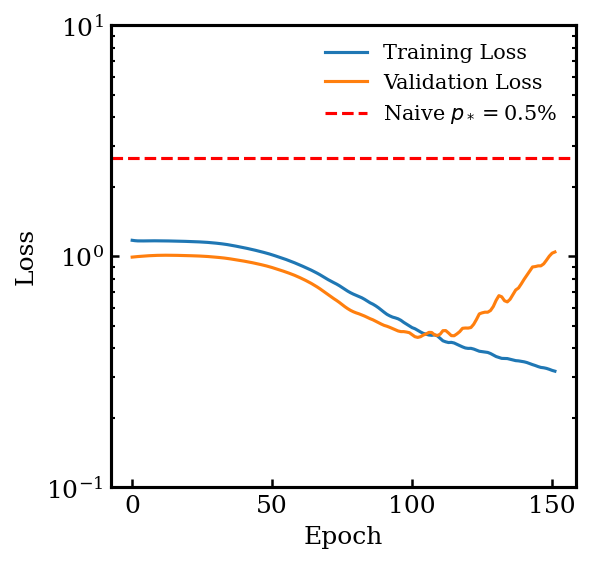

In [76]:
# Plot the training and validation losses
plt.figure(figsize=(4,4))
plt.plot(training_loss_history, label='Training Loss')
plt.plot(validation_loss_history, label='Validation Loss')
# naive baseline loss is the loss if we randomly predict 1 for each star with prob = fraction of stars in stream track
fraction_guess = 0.005
naive_baseline_loss = -pos_weight*fraction_guess*np.log(fraction_guess)-(1-fraction_guess)*np.log(1-fraction_guess)
plt.axhline(naive_baseline_loss,ls='--',color='r',label=rf'Naive $p_*=${fraction_guess*100:.1f}%')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend(loc='best',fontsize='small',frameon=False,framealpha=0.75)
plt.ylim(1e-1,1e1)

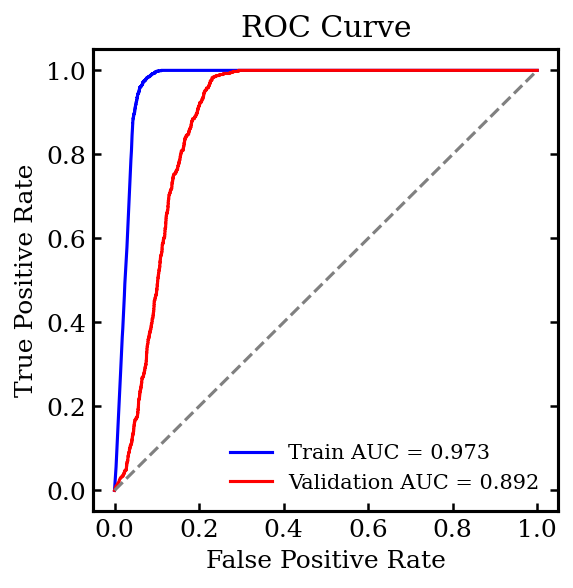

In [34]:
# Computing the ROC Curve for the network with the training and validation data

model.eval()
with torch.no_grad():
    # Get the predicted probabilities for training data
    #train_outputs = model(graph_train)
    if IGNNbool:
        train_outputs, train_edge_outputs = model(graph_train)
    else:
        train_outputs = model(graph_train)
    train_probs = torch.sigmoid(train_outputs).cpu().numpy()
    train_labels = graph_train.y.cpu().numpy()

    # Get the predicted probabilities for validation data
    #val_outputs = model(graph_val)
    if IGNNbool:
        val_outputs, val_edge_outputs = model(graph_val)
    else:
        val_outputs = model(graph_val)
    val_probs = torch.sigmoid(val_outputs).cpu().numpy()
    val_labels = graph_val.y.cpu().numpy()

# Compute ROC curve for training data
train_fpr, train_tpr, _ = roc_curve(train_labels, train_probs)
train_auc = auc(train_fpr, train_tpr)

# Compute ROC curve for validation data
val_fpr, val_tpr, _ = roc_curve(val_labels, val_probs)
val_auc = auc(val_fpr, val_tpr)

plt.figure(figsize=(4,4))
plt.plot(train_fpr, train_tpr, color='blue', label=f'Train AUC = {train_auc:.3f}')
plt.plot(val_fpr, val_tpr, color='red', label=f'Validation AUC = {val_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
#plt.xscale('log'); plt.yscale('log')
#plt.grid(True)
plt.show()

Mean theta_0 for conv1: 0.031205249950289726, Shape for Theta_0: torch.Size([32, 6])
Mean theta_1 for conv1: 0.006634989287704229, Shape for Theta_1: torch.Size([32, 6])


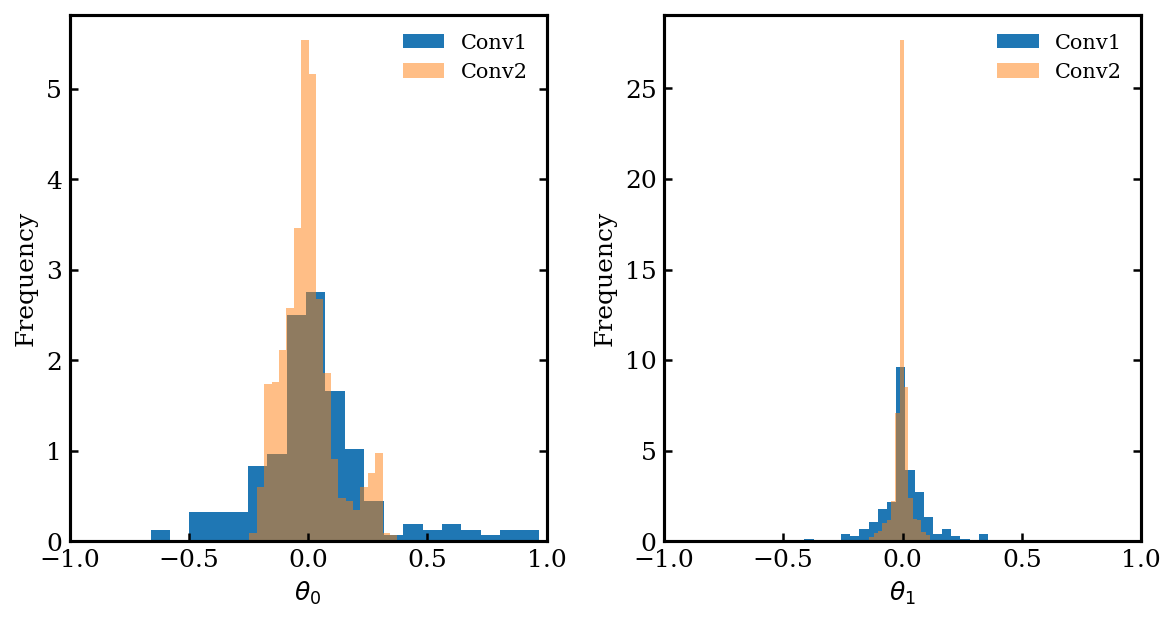

In [25]:
## Debugging output of ChebConv (if that's what you're using)

# Print weights for conv1 layer:
print(f"Mean theta_0 for conv1: {model.conv1.lins[0].weight.mean()}, Shape for Theta_0: {model.conv1.lins[0].weight.shape}")
print(f"Mean theta_1 for conv1: {model.conv1.lins[1].weight.mean()}, Shape for Theta_1: {model.conv1.lins[1].weight.shape}")

# plot histogram for theta_0 and theta_1 for conv1, conv2, conv3 but separate plots for each theta
# plot subplots for each theta for conv1, conv2, conv3

nbins = 20
xlims = [-1.0,1.0]

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.hist(model.conv1.lins[0].weight.detach().numpy().flatten(),bins=nbins,label='Conv1',density=True)
plt.hist(model.conv2.lins[0].weight.detach().numpy().flatten(),bins=nbins,label='Conv2',alpha=0.5,density=True)
plt.xlabel(r'$\theta_0$')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.xlim(xlims)
plt.subplot(2,2,2)
plt.hist(model.conv1.lins[1].weight.detach().numpy().flatten(),bins=nbins,label='Conv1',density=True)
plt.hist(model.conv2.lins[1].weight.detach().numpy().flatten(),bins=nbins,label='Conv2',alpha=0.5,density=True)
plt.xlabel(r'$\theta_1$')
plt.ylabel('Frequency')
plt.legend(loc='best')
plt.xlim(xlims)
plt.tight_layout()
